In [1]:
!pip install pyarrow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


 Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.feather as feather

# Set plot style
sns.set(style="whitegrid")

FEATURE_COLUMNS = ['pdu_sum_cpu_usage', 'production_power_util']

Load Dataset

In [3]:
# Load feather file
feather_path = "merged_data_cell_a_pdu6_pdu7_approx100machines_30d.feather"
df = feather.read_feather(feather_path)

# keep only one PDU for consistency
df = df[df["pdu"] == "pdu6"].copy()

# Display shape and preview
print(f"Shape: {df.shape}")
df.head()

Shape: (2881, 10)


,datetime,pdu,cell,pdu_avg_cpu_usage,pdu_sum_cpu_usage,pdu_avg_memory_usage,pdu_sum_memory_usage,machine_count_in_pdu_subset,measured_power_util,production_power_util
0,1970-01-01 00:00:00,pdu6,a,0.005723,0.286154,0.004259,0.212931,50,0.659000,0.596000
2,1970-01-01 00:15:00,pdu6,a,0.006106,0.305293,0.004228,0.211401,50,0.664667,0.603000
4,1970-01-01 00:30:00,pdu6,a,0.006353,0.317627,0.004260,0.212976,50,0.680000,0.606667
6,1970-01-01 00:45:00,pdu6,a,0.005534,0.276702,0.004205,0.210270,50,0.661667,0.604667
8,1970-01-01 01:00:00,pdu6,a,0.004787,0.239361,0.004056,0.202796,50,0.623333,0.600333


In [4]:
df = df[FEATURE_COLUMNS]
print("After feature filter:", df.shape)

After feature filter: (2881, 2)


In [5]:
df.head()

,pdu_sum_cpu_usage,production_power_util
0,0.286154,0.596000
2,0.305293,0.603000
4,0.317627,0.606667
6,0.276702,0.604667
8,0.239361,0.600333


Segment Time Series into Daily Windows (96 time steps = 1 day)

In [6]:
def create_windows(data, window_size=96, step_size=1):
    sequences = []
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        window = data.iloc[start:end].values
        sequences.append(window)
    return np.array(sequences)

windowed_data = create_windows(df, window_size=96)
print("Windowed data shape:", windowed_data.shape)

Windowed data shape: (2785, 96, 2)


Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(windowed_data, test_size=0.2, random_state=42)

np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

Train shape: (2228, 96, 2), Validation shape: (557, 96, 2)


Train LSTM Model (using train_lstm_model.py)

2025-05-11 21:28:54,478 - INFO - --- Starting PyTorch LSTM Model Training Pipeline ---
2025-05-11 21:28:54,478 - INFO - Using device: cpu
2025-05-11 21:28:54,479 - INFO - Loading data from merged_data_cell_a_pdu6_pdu7_approx100machines_30d.feather...
2025-05-11 21:28:54,481 - INFO - Data loaded successfully. Shape: (5762, 10)
2025-05-11 21:28:54,482 - INFO - Filtering data for PDU: pdu6
2025-05-11 21:28:54,484 - INFO - Data for PDU pdu6 shape: (2881, 9)
2025-05-11 21:28:54,484 - INFO - Selecting features: ['pdu_sum_cpu_usage', 'production_power_util'] and target: production_power_util
2025-05-11 21:28:54,484 - INFO - Normalizing data...
2025-05-11 21:28:54,485 - INFO - Creating sequences with length: 96
2025-05-11 21:28:54,488 - INFO - Sequences created. X shape: (2785, 96, 2), y shape: (2785,)
2025-05-11 21:28:54,489 - INFO - Splitting data into training and testing sets...
2025-05-11 21:28:54,489 - INFO - X_train: (2228, 96, 2), y_train: (2228,), X_test: (557, 96, 2), y_test: (557,)


2025-05-11 21:30:29,615 - INFO - Early stopping triggered at epoch 49.
2025-05-11 21:30:29,615 - INFO - Model training finished in 94.55 seconds.
2025-05-11 21:30:29,617 - INFO - Loaded best model from pytorch_lstm_model_output/pytorch_lstm_model_pdu_pdu6_best.pth for evaluation.
LSTM output saved to pytorch_lstm_model_output/output.npy, shape: (100, 1)
2025-05-11 21:30:29,796 - INFO - Test Loss (MSE, scaled): 0.002171


/Users/yao/SMU/CS 8341 Mach Lrng & Neural Ntwrks/AI-Data-Center-Load-Modeling-main/train_lstm_model.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_di

2025-05-11 21:30:29,932 - INFO - Loss curve saved to pytorch_lstm_model_output/pytorch_lstm_loss_curve_pdu_pdu6.png
2025-05-11 21:30:30,101 - INFO - Predictions plot saved to pytorch_lstm_model_output/pytorch_lstm_predictions_pdu_pdu6.png
2025-05-11 21:30:30,102 - INFO - --- PyTorch LSTM Model Training Pipeline Finished in 95.62 seconds ---


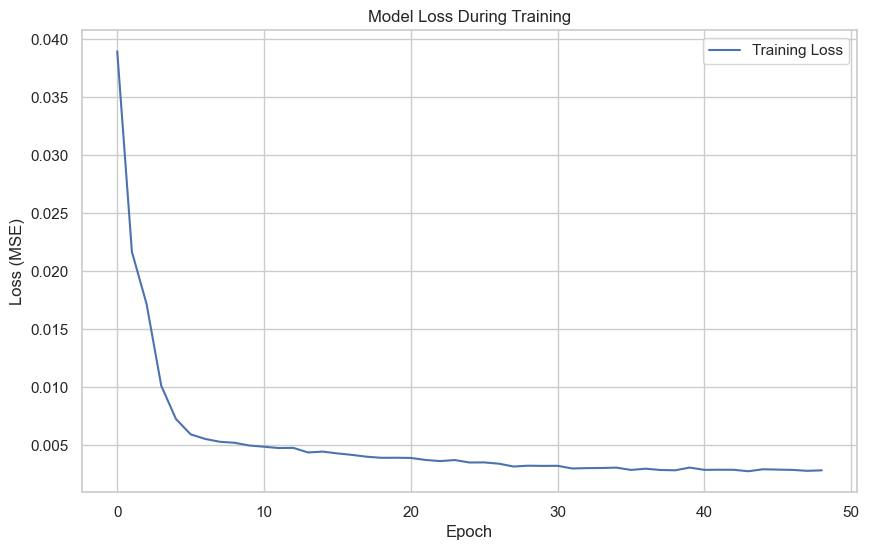

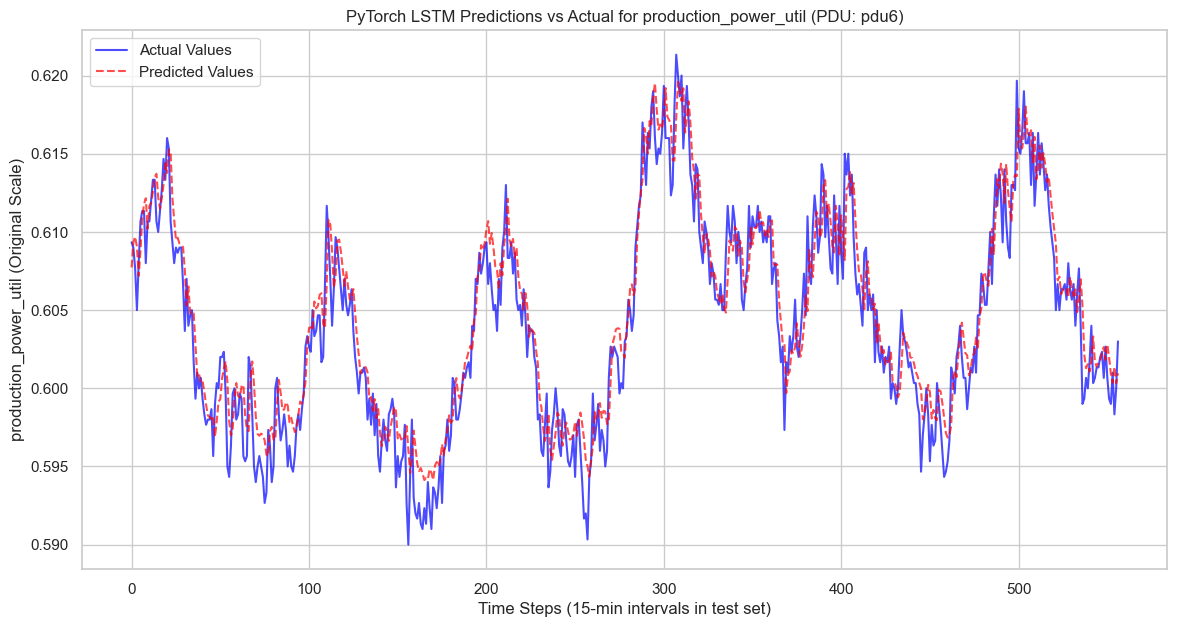

In [8]:
# Load and run training script
%run train_lstm_model.py

Train VAE Model (using train_vae_model.py)

2025-05-11 21:30:30,292 - INFO - --- Starting PyTorch VAE Model Training Pipeline ---
2025-05-11 21:30:30,293 - INFO - Using device: cpu
2025-05-11 21:30:30,293 - INFO - Loading data from merged_data_cell_a_pdu6_pdu7_approx100machines_30d.feather...
2025-05-11 21:30:30,295 - INFO - Data loaded successfully. Shape: (5762, 10)
2025-05-11 21:30:30,296 - INFO - Filtering data for PDU: pdu6
2025-05-11 21:30:30,297 - INFO - Data for PDU pdu6 shape: (2881, 9)
2025-05-11 21:30:30,297 - INFO - Selecting features for VAE: ['pdu_sum_cpu_usage', 'production_power_util']
2025-05-11 21:30:30,297 - INFO - Normalizing data for VAE...
2025-05-11 21:30:30,298 - INFO - Creating sequences for VAE with length: 96
2025-05-11 21:30:30,301 - INFO - VAE sequences created. Shape: (2786, 96, 2)
2025-05-11 21:30:30,302 - INFO - Train sequences: (2228, 96, 2), Test sequences: (558, 96, 2)
2025-05-11 21:30:30,303 - INFO - Building PyTorch VAE model...
2025-05-11 21:30:30,305 - INFO - TimeSeriesVAE(
  (encoder_lstm)

2025-05-11 21:32:38,649 - INFO - Epoch 65/100, Total Loss: 2.102955, Recon Loss: 2.088719, KLD: 56.944611
2025-05-11 21:32:40,638 - INFO - Epoch 66/100, Total Loss: 2.001994, Recon Loss: 1.987581, KLD: 57.650280
2025-05-11 21:32:42,605 - INFO - Epoch 67/100, Total Loss: 1.931990, Recon Loss: 1.917274, KLD: 58.864175
2025-05-11 21:32:44,560 - INFO - Epoch 68/100, Total Loss: 1.841457, Recon Loss: 1.826403, KLD: 60.216711
2025-05-11 21:32:46,506 - INFO - Epoch 69/100, Total Loss: 1.847739, Recon Loss: 1.832445, KLD: 61.177773
2025-05-11 21:32:48,470 - INFO - Epoch 70/100, Total Loss: 1.912522, Recon Loss: 1.897289, KLD: 60.932122
2025-05-11 21:32:50,424 - INFO - Epoch 71/100, Total Loss: 1.717035, Recon Loss: 1.701588, KLD: 61.789341
2025-05-11 21:32:52,367 - INFO - Epoch 72/100, Total Loss: 1.708953, Recon Loss: 1.693430, KLD: 62.091847
2025-05-11 21:32:54,311 - INFO - Epoch 73/100, Total Loss: 1.707158, Recon Loss: 1.691549, KLD: 62.433243
2025-05-11 21:32:56,295 - INFO - Epoch 74/100,

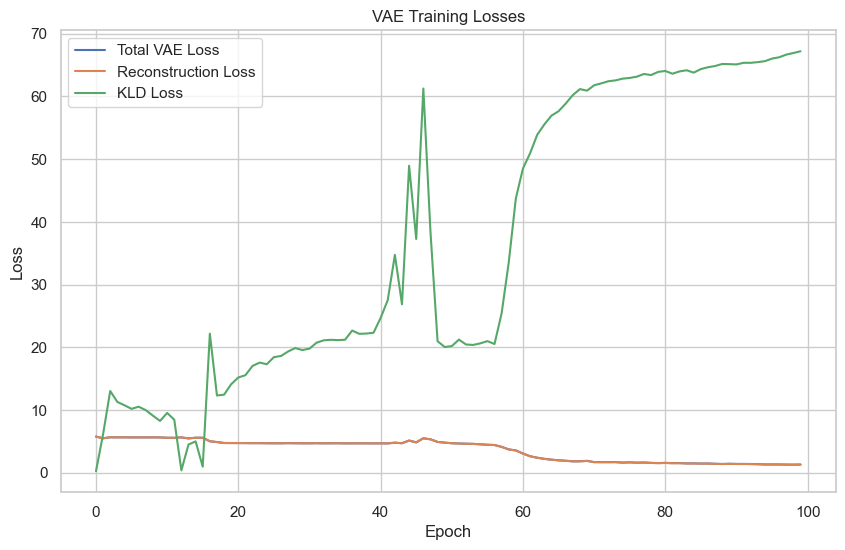

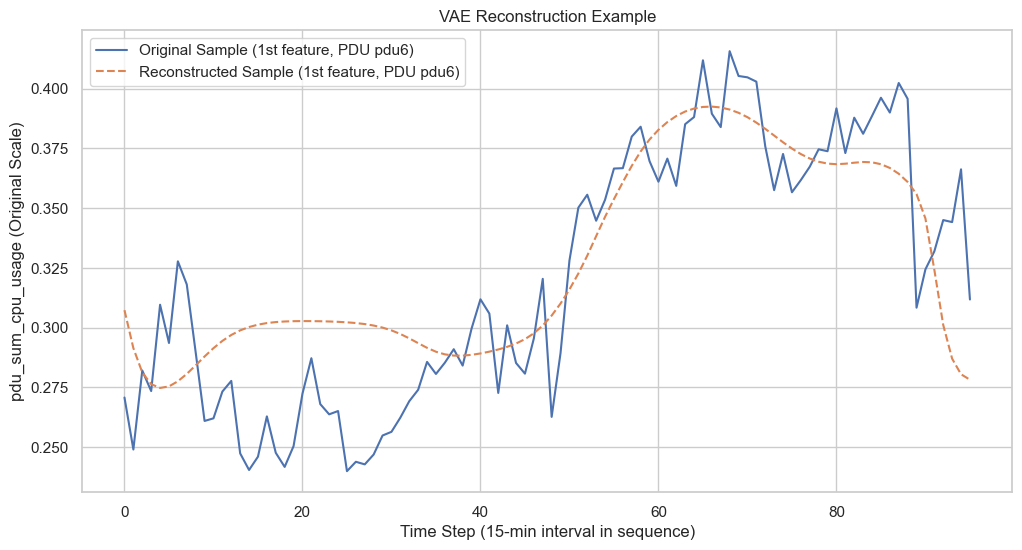

In [9]:
# Load and run training script
%run train_vae_model.py

 Train Diffusion Model (TimeGrad or DiffTime)

In [10]:
# Run diffusion model notebook or script
%run tdiffusion_time_series.ipynb

2025-05-11 21:33:49,227 - INFO - Using device: cpu
2025-05-11 21:33:49,233 - INFO - Training with params: {'batch_size': 16, 'latent_dim': 16, 'learning_rate': 0.001, 'window_size': 64}
2025-05-11 21:33:49,353 - INFO - Epoch 1/100 | Train Loss: 0.920030 | Val Loss: 0.777298
2025-05-11 21:33:49,462 - INFO - Epoch 2/100 | Train Loss: 0.665275 | Val Loss: 0.580366
2025-05-11 21:33:49,567 - INFO - Epoch 3/100 | Train Loss: 0.518672 | Val Loss: 0.473544
2025-05-11 21:33:49,667 - INFO - Epoch 4/100 | Train Loss: 0.441080 | Val Loss: 0.416187
2025-05-11 21:33:49,764 - INFO - Epoch 5/100 | Train Loss: 0.391870 | Val Loss: 0.374764
2025-05-11 21:33:49,861 - INFO - Epoch 6/100 | Train Loss: 0.355817 | Val Loss: 0.338564
2025-05-11 21:33:49,978 - INFO - Epoch 7/100 | Train Loss: 0.319689 | Val Loss: 0.309296
2025-05-11 21:33:50,085 - INFO - Epoch 8/100 | Train Loss: 0.309054 | Val Loss: 0.311822
2025-05-11 21:33:50,188 - INFO - Epoch 9/100 | Train Loss: 0.293430 | Val Loss: 0.276096
2025-05-11 21

2025-05-11 21:33:57,950 - INFO - Epoch 6/100 | Train Loss: 0.452088 | Val Loss: 0.420208
2025-05-11 21:33:58,043 - INFO - Epoch 7/100 | Train Loss: 0.410681 | Val Loss: 0.403986
2025-05-11 21:33:58,141 - INFO - Epoch 8/100 | Train Loss: 0.382889 | Val Loss: 0.358787
2025-05-11 21:33:58,237 - INFO - Epoch 9/100 | Train Loss: 0.358664 | Val Loss: 0.344284
2025-05-11 21:33:58,327 - INFO - Epoch 10/100 | Train Loss: 0.333345 | Val Loss: 0.325648
2025-05-11 21:33:58,425 - INFO - Epoch 11/100 | Train Loss: 0.323845 | Val Loss: 0.307749
2025-05-11 21:33:58,510 - INFO - Epoch 12/100 | Train Loss: 0.316403 | Val Loss: 0.312544
2025-05-11 21:33:58,596 - INFO - Epoch 13/100 | Train Loss: 0.291291 | Val Loss: 0.284392
2025-05-11 21:33:58,691 - INFO - Epoch 14/100 | Train Loss: 0.289012 | Val Loss: 0.287006
2025-05-11 21:33:58,775 - INFO - Epoch 15/100 | Train Loss: 0.271284 | Val Loss: 0.265528
2025-05-11 21:33:58,862 - INFO - Epoch 16/100 | Train Loss: 0.263231 | Val Loss: 0.267937
2025-05-11 21:

2025-05-11 21:34:06,419 - INFO - Early stopping triggered.
2025-05-11 21:34:06,420 - INFO - Training with params: {'batch_size': 16, 'latent_dim': 16, 'learning_rate': 0.0005, 'window_size': 96}
2025-05-11 21:34:06,513 - INFO - Epoch 1/100 | Train Loss: 0.984160 | Val Loss: 0.950909
2025-05-11 21:34:06,633 - INFO - Epoch 2/100 | Train Loss: 0.884954 | Val Loss: 0.826507
2025-05-11 21:34:06,727 - INFO - Epoch 3/100 | Train Loss: 0.772551 | Val Loss: 0.744391
2025-05-11 21:34:06,826 - INFO - Epoch 4/100 | Train Loss: 0.701472 | Val Loss: 0.673143
2025-05-11 21:34:06,929 - INFO - Epoch 5/100 | Train Loss: 0.658785 | Val Loss: 0.635933
2025-05-11 21:34:07,030 - INFO - Epoch 6/100 | Train Loss: 0.618802 | Val Loss: 0.601138
2025-05-11 21:34:07,138 - INFO - Epoch 7/100 | Train Loss: 0.589904 | Val Loss: 0.571544
2025-05-11 21:34:07,237 - INFO - Epoch 8/100 | Train Loss: 0.567118 | Val Loss: 0.547123
2025-05-11 21:34:07,327 - INFO - Epoch 9/100 | Train Loss: 0.546255 | Val Loss: 0.539313
2025

2025-05-11 21:34:14,533 - INFO - Epoch 11/100 | Train Loss: 0.497838 | Val Loss: 0.492955
2025-05-11 21:34:14,633 - INFO - Epoch 12/100 | Train Loss: 0.489806 | Val Loss: 0.479140
2025-05-11 21:34:14,737 - INFO - Epoch 13/100 | Train Loss: 0.487985 | Val Loss: 0.484449
2025-05-11 21:34:14,840 - INFO - Epoch 14/100 | Train Loss: 0.481221 | Val Loss: 0.481845
2025-05-11 21:34:14,937 - INFO - Epoch 15/100 | Train Loss: 0.481464 | Val Loss: 0.474660
2025-05-11 21:34:15,034 - INFO - Epoch 16/100 | Train Loss: 0.477687 | Val Loss: 0.471124
2025-05-11 21:34:15,130 - INFO - Epoch 17/100 | Train Loss: 0.478633 | Val Loss: 0.478051
2025-05-11 21:34:15,231 - INFO - Epoch 18/100 | Train Loss: 0.476542 | Val Loss: 0.485247
2025-05-11 21:34:15,318 - INFO - Epoch 19/100 | Train Loss: 0.477006 | Val Loss: 0.483175
2025-05-11 21:34:15,423 - INFO - Epoch 20/100 | Train Loss: 0.476383 | Val Loss: 0.481802
2025-05-11 21:34:15,507 - INFO - Epoch 21/100 | Train Loss: 0.479098 | Val Loss: 0.478377
2025-05-11

2025-05-11 21:34:22,930 - INFO - Epoch 64/100 | Train Loss: 0.157385 | Val Loss: 0.158493
2025-05-11 21:34:23,014 - INFO - Epoch 65/100 | Train Loss: 0.172778 | Val Loss: 0.157568
2025-05-11 21:34:23,014 - INFO - Early stopping triggered.
2025-05-11 21:34:23,014 - INFO - Training with params: {'batch_size': 16, 'latent_dim': 32, 'learning_rate': 0.0005, 'window_size': 96}
2025-05-11 21:34:23,099 - INFO - Epoch 1/100 | Train Loss: 0.982659 | Val Loss: 0.942228
2025-05-11 21:34:23,192 - INFO - Epoch 2/100 | Train Loss: 0.881226 | Val Loss: 0.814019
2025-05-11 21:34:23,284 - INFO - Epoch 3/100 | Train Loss: 0.762077 | Val Loss: 0.718665
2025-05-11 21:34:23,379 - INFO - Epoch 4/100 | Train Loss: 0.695911 | Val Loss: 0.664796
2025-05-11 21:34:23,469 - INFO - Epoch 5/100 | Train Loss: 0.638911 | Val Loss: 0.631962
2025-05-11 21:34:23,589 - INFO - Epoch 6/100 | Train Loss: 0.607346 | Val Loss: 0.586395
2025-05-11 21:34:23,708 - INFO - Epoch 7/100 | Train Loss: 0.577786 | Val Loss: 0.565116
20

2025-05-11 21:34:29,653 - INFO - Epoch 50/100 | Train Loss: 0.179424 | Val Loss: 0.173176
2025-05-11 21:34:29,721 - INFO - Epoch 51/100 | Train Loss: 0.182272 | Val Loss: 0.168927
2025-05-11 21:34:29,776 - INFO - Epoch 52/100 | Train Loss: 0.183366 | Val Loss: 0.174975
2025-05-11 21:34:29,842 - INFO - Epoch 53/100 | Train Loss: 0.181083 | Val Loss: 0.180679
2025-05-11 21:34:29,915 - INFO - Epoch 54/100 | Train Loss: 0.177500 | Val Loss: 0.180394
2025-05-11 21:34:29,981 - INFO - Epoch 55/100 | Train Loss: 0.178446 | Val Loss: 0.171428
2025-05-11 21:34:30,053 - INFO - Epoch 56/100 | Train Loss: 0.164756 | Val Loss: 0.164211
2025-05-11 21:34:30,114 - INFO - Epoch 57/100 | Train Loss: 0.176128 | Val Loss: 0.175919
2025-05-11 21:34:30,194 - INFO - Epoch 58/100 | Train Loss: 0.178388 | Val Loss: 0.172452
2025-05-11 21:34:30,248 - INFO - Epoch 59/100 | Train Loss: 0.172234 | Val Loss: 0.171132
2025-05-11 21:34:30,298 - INFO - Epoch 60/100 | Train Loss: 0.168904 | Val Loss: 0.188562
2025-05-11

2025-05-11 21:34:35,226 - INFO - Epoch 47/100 | Train Loss: 0.446677 | Val Loss: 0.446312
2025-05-11 21:34:35,287 - INFO - Epoch 48/100 | Train Loss: 0.441767 | Val Loss: 0.449530
2025-05-11 21:34:35,341 - INFO - Epoch 49/100 | Train Loss: 0.448115 | Val Loss: 0.455971
2025-05-11 21:34:35,394 - INFO - Epoch 50/100 | Train Loss: 0.443767 | Val Loss: 0.444641
2025-05-11 21:34:35,449 - INFO - Epoch 51/100 | Train Loss: 0.443537 | Val Loss: 0.436102
2025-05-11 21:34:35,501 - INFO - Epoch 52/100 | Train Loss: 0.443860 | Val Loss: 0.436296
2025-05-11 21:34:35,556 - INFO - Epoch 53/100 | Train Loss: 0.441694 | Val Loss: 0.447780
2025-05-11 21:34:35,608 - INFO - Epoch 54/100 | Train Loss: 0.447341 | Val Loss: 0.450920
2025-05-11 21:34:35,657 - INFO - Epoch 55/100 | Train Loss: 0.447502 | Val Loss: 0.442871
2025-05-11 21:34:35,706 - INFO - Epoch 56/100 | Train Loss: 0.451771 | Val Loss: 0.459323
2025-05-11 21:34:35,706 - INFO - Early stopping triggered.
2025-05-11 21:34:35,706 - INFO - Training

2025-05-11 21:34:40,421 - INFO - Epoch 80/100 | Train Loss: 0.156413 | Val Loss: 0.161136
2025-05-11 21:34:40,484 - INFO - Epoch 81/100 | Train Loss: 0.160057 | Val Loss: 0.167183
2025-05-11 21:34:40,557 - INFO - Epoch 82/100 | Train Loss: 0.161677 | Val Loss: 0.171836
2025-05-11 21:34:40,620 - INFO - Epoch 83/100 | Train Loss: 0.151377 | Val Loss: 0.158488
2025-05-11 21:34:40,621 - INFO - Early stopping triggered.
2025-05-11 21:34:40,621 - INFO - Training with params: {'batch_size': 32, 'latent_dim': 16, 'learning_rate': 0.0005, 'window_size': 96}
2025-05-11 21:34:40,686 - INFO - Epoch 1/100 | Train Loss: 0.996323 | Val Loss: 0.973890
2025-05-11 21:34:40,748 - INFO - Epoch 2/100 | Train Loss: 0.943903 | Val Loss: 0.899731
2025-05-11 21:34:40,810 - INFO - Epoch 3/100 | Train Loss: 0.854842 | Val Loss: 0.818905
2025-05-11 21:34:40,868 - INFO - Epoch 4/100 | Train Loss: 0.788419 | Val Loss: 0.745982
2025-05-11 21:34:40,930 - INFO - Epoch 5/100 | Train Loss: 0.727734 | Val Loss: 0.701941


2025-05-11 21:34:45,647 - INFO - Epoch 28/100 | Train Loss: 0.207347 | Val Loss: 0.212590
2025-05-11 21:34:45,707 - INFO - Epoch 29/100 | Train Loss: 0.203140 | Val Loss: 0.204725
2025-05-11 21:34:45,763 - INFO - Epoch 30/100 | Train Loss: 0.207166 | Val Loss: 0.207972
2025-05-11 21:34:45,821 - INFO - Epoch 31/100 | Train Loss: 0.200609 | Val Loss: 0.201975
2025-05-11 21:34:45,878 - INFO - Epoch 32/100 | Train Loss: 0.199255 | Val Loss: 0.206283
2025-05-11 21:34:45,935 - INFO - Epoch 33/100 | Train Loss: 0.198460 | Val Loss: 0.190699
2025-05-11 21:34:45,994 - INFO - Epoch 34/100 | Train Loss: 0.199438 | Val Loss: 0.220451
2025-05-11 21:34:46,049 - INFO - Epoch 35/100 | Train Loss: 0.199744 | Val Loss: 0.200611
2025-05-11 21:34:46,101 - INFO - Epoch 36/100 | Train Loss: 0.196250 | Val Loss: 0.193650
2025-05-11 21:34:46,154 - INFO - Epoch 37/100 | Train Loss: 0.194371 | Val Loss: 0.198265
2025-05-11 21:34:46,203 - INFO - Epoch 38/100 | Train Loss: 0.193742 | Val Loss: 0.185741
2025-05-11

2025-05-11 21:34:50,433 - INFO - Epoch 28/100 | Train Loss: 0.241679 | Val Loss: 0.236474
2025-05-11 21:34:50,487 - INFO - Epoch 29/100 | Train Loss: 0.241732 | Val Loss: 0.215405
2025-05-11 21:34:50,546 - INFO - Epoch 30/100 | Train Loss: 0.235714 | Val Loss: 0.227409
2025-05-11 21:34:50,604 - INFO - Epoch 31/100 | Train Loss: 0.226587 | Val Loss: 0.221621
2025-05-11 21:34:50,659 - INFO - Epoch 32/100 | Train Loss: 0.220050 | Val Loss: 0.212518
2025-05-11 21:34:50,724 - INFO - Epoch 33/100 | Train Loss: 0.216999 | Val Loss: 0.231299
2025-05-11 21:34:50,784 - INFO - Epoch 34/100 | Train Loss: 0.220196 | Val Loss: 0.222821
2025-05-11 21:34:50,838 - INFO - Epoch 35/100 | Train Loss: 0.215948 | Val Loss: 0.222304
2025-05-11 21:34:50,887 - INFO - Epoch 36/100 | Train Loss: 0.201551 | Val Loss: 0.211597
2025-05-11 21:34:50,948 - INFO - Epoch 37/100 | Train Loss: 0.206353 | Val Loss: 0.206729
2025-05-11 21:34:50,998 - INFO - Epoch 38/100 | Train Loss: 0.208778 | Val Loss: 0.199114
2025-05-11

2025-05-11 21:34:55,446 - INFO - Epoch 25/100 | Train Loss: 0.465554 | Val Loss: 0.463839
2025-05-11 21:34:55,504 - INFO - Epoch 26/100 | Train Loss: 0.464243 | Val Loss: 0.447364
2025-05-11 21:34:55,564 - INFO - Epoch 27/100 | Train Loss: 0.460250 | Val Loss: 0.455174
2025-05-11 21:34:55,622 - INFO - Epoch 28/100 | Train Loss: 0.461246 | Val Loss: 0.461201
2025-05-11 21:34:55,685 - INFO - Epoch 29/100 | Train Loss: 0.463597 | Val Loss: 0.460244
2025-05-11 21:34:55,746 - INFO - Epoch 30/100 | Train Loss: 0.453201 | Val Loss: 0.460498
2025-05-11 21:34:55,805 - INFO - Epoch 31/100 | Train Loss: 0.451218 | Val Loss: 0.454198
2025-05-11 21:34:55,860 - INFO - Epoch 32/100 | Train Loss: 0.450863 | Val Loss: 0.456797
2025-05-11 21:34:55,948 - INFO - Epoch 33/100 | Train Loss: 0.456839 | Val Loss: 0.452824
2025-05-11 21:34:56,010 - INFO - Epoch 34/100 | Train Loss: 0.450038 | Val Loss: 0.441367
2025-05-11 21:34:56,066 - INFO - Epoch 35/100 | Train Loss: 0.450267 | Val Loss: 0.446447
2025-05-11

Run Diffusion Analysis / Visual Comparison

best_diffusion_w64_ld16_lr0.0005.pth: Val Loss = 0.182507
best_diffusion_w64_ld32_lr0.0005.pth: Val Loss = 0.154483
best_diffusion_w96_ld32_lr0.0005.pth: Val Loss = 0.445224
best_diffusion_w96_ld32_lr0.001.pth: Val Loss = 0.474943
best_diffusion_w64_ld32_lr0.001.pth: Val Loss = 0.191030
best_diffusion_w96_ld16_lr0.0005.pth: Val Loss = 0.451662
best_diffusion_w96_ld16_lr0.001.pth: Val Loss = 0.439030
best_diffusion_w64_ld16_lr0.001.pth: Val Loss = 0.153889
Best model: best_diffusion_w64_ld16_lr0.001.pth Validation Loss: 0.1538887292974525
Number of real windows: (2818, 64, 2)


/var/folders/71/srz_2n1n5fs5rck76qllpx800000gn/T/ipykernel_60087/2500343284.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(OUTPUT_DIR, f

Number of generated windows: (2818, 64, 2)
MMD: 0.697750
Mean Wasserstein Distance: 34.789735
Feature 0 KS statistic = 0.5152, p-value = 0.0000e+00
Feature 1 KS statistic = 0.5298, p-value = 0.0000e+00

Global KS statistic = 0.5024, p-value = 0.0000e+00


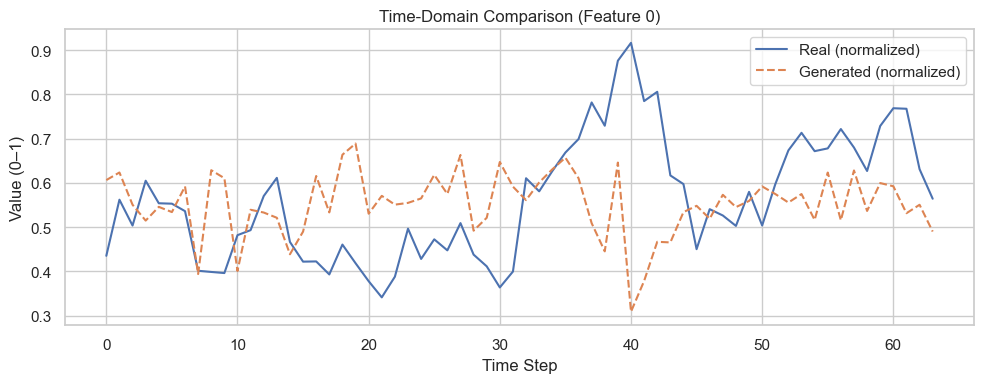

/opt/anaconda3/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 64, using nperseg = 64
  warnings.warn('nperseg = {0:d} is greater than input length '


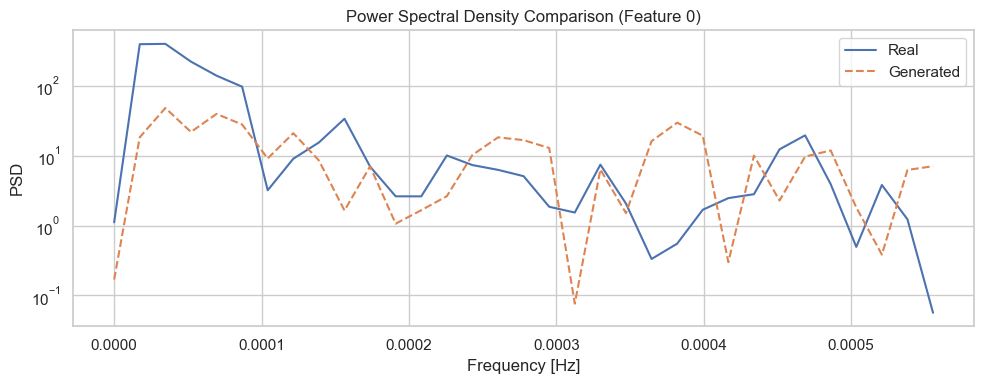

Real windows: (2818, 64, 2)


/var/folders/71/srz_2n1n5fs5rck76qllpx800000gn/T/ipykernel_60087/366303747.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CHECKPOINT, map_location=d

Generated windows: (2818, 64, 2)
Real data -> Avg Grid Draw: 0.4848, Avg Violations: 0.81
Gen data  -> Avg Grid Draw: -2.6932, Avg Violations: 30.18


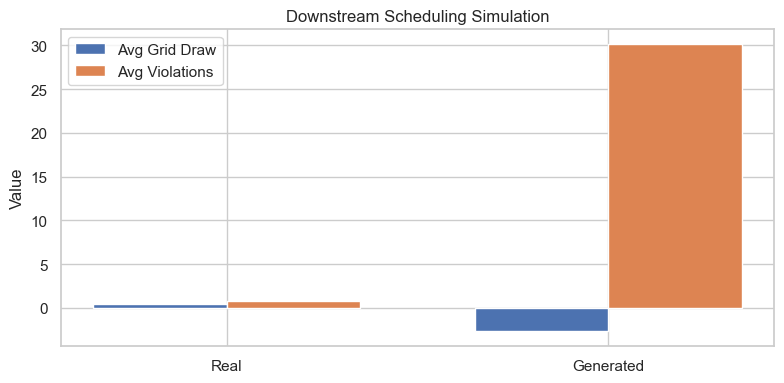

In [11]:
# Run diffusion result analysis
%run diff_analysis.ipynb

### Evaluation

register the TimeSeriesDiffusionModel with .sample()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Positional time embedding
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -(np.log(10000) / (half_dim - 1)))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb

# Denoising MLP model
class Denoiser(nn.Module):
    def __init__(self, window_size, feature_dim, latent_dim):
        super().__init__()
        input_dim = window_size * feature_dim + latent_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, window_size * feature_dim)
        )

    def forward(self, x, t_emb):
        h = torch.cat([x, t_emb], dim=1)
        return self.net(h)

# Main diffusion model class
class TimeSeriesDiffusionModel:
    def __init__(self, window_size, feature_dim, latent_dim, lr, batch_size, device):
        self.window_size = window_size
        self.feature_dim = feature_dim
        self.latent_dim = latent_dim
        self.lr = lr
        self.batch_size = batch_size
        self.device = device

        self.NOISE_STEPS = 1000
        self.betas = torch.linspace(1e-4, 0.02, self.NOISE_STEPS).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        self.model = Denoiser(window_size, feature_dim, latent_dim).to(device)
        self.pos_emb = SinusoidalPosEmb(latent_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def sample(self, num_samples):
        """Generate synthetic samples using the learned reverse process."""
        self.model.eval()
        x = torch.randn(num_samples, self.window_size * self.feature_dim).to(self.device)

        for t in reversed(range(self.NOISE_STEPS)):
            t_tensor = torch.full((num_samples,), t, device=self.device, dtype=torch.long)
            t_emb = self.pos_emb(t_tensor)
            pred_noise = self.model(x, t_emb)

            alpha = self.alphas[t]
            alpha_hat = self.alphas_cumprod[t]
            beta = self.betas[t]

            noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
            x = (1 / alpha**0.5) * (x - ((1 - alpha) / (1 - alpha_hat)**0.5) * pred_noise) + (beta**0.5) * noise

        return x.view(-1, self.window_size, self.feature_dim)

Generate and diffusin Save Samples

In [13]:
# Re-instantiate with the *best* hyperparameters from your log:
feature_dim = len(FEATURE_COLUMNS)                    # still 2
model = TimeSeriesDiffusionModel(
    window_size=64,                                   # ← was 96
    feature_dim=feature_dim,
    latent_dim=32,                                    # matches best_params
    lr=0.001,                                         # ← was 0.0005
    batch_size=32,                                    # matches best_params
    device=device
)

# Load *that* best checkpoint:
checkpoint = f"diffusion_model_output/best_diffusion_w{model.window_size}_ld{model.latent_dim}_lr{model.lr}.pth"
model.model.load_state_dict(torch.load(checkpoint, map_location=device))
model.model.eval()

# Sample:
with torch.no_grad():
    synthetic = model.sample(num_samples=100)        # will now be shape (100, 64, 2)
    synthetic = synthetic.clamp(0.0, 1.0)

# Invert back into original units exactly as before:
X_val = np.load("X_val.npy", allow_pickle=True)      # shape (N, 64, 2) if you re-generated your windows
flat_real = X_val.reshape(-1,  X_val.shape[-1])
scaler = MinMaxScaler().fit(flat_real)

raw_syn = synthetic.cpu().numpy().reshape(-1, synthetic.shape[-1])
restored = scaler.inverse_transform(raw_syn).reshape(synthetic.shape)

np.save("diffusion_model_output/output.npy", restored)
print("Restored diffusion output saved to diffusion_model_output/output.npy")

/var/folders/71/srz_2n1n5fs5rck76qllpx800000gn/T/ipykernel_60087/931755846.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.model.load_state_dict(torch.load(checkp

Restored diffusion output saved to diffusion_model_output/output.npy


In [14]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load real validation data
X_val = np.load("X_val.npy", allow_pickle=True)

real_flat = X_val.reshape(-1, X_val.shape[-1])  # shape (N, 2)
scaler = MinMaxScaler()
scaler.fit(real_flat)

synthetic_np = synthetic.cpu().numpy().reshape(-1, synthetic.shape[-1])
restored = scaler.inverse_transform(synthetic_np).reshape(synthetic.shape)

np.save("diffusion_model_output/output.npy", restored)
print("Saved restored diffusion output to diffusion_model_output/output.npy")

Saved restored diffusion output to diffusion_model_output/output.npy


In [15]:
import numpy as np
import os

model_outputs = {
    "LSTM": "pytorch_lstm_model_output/output.npy",
    "VAE": "vae_model_output/output.npy",
    "Diffusion": "diffusion_model_output/output.npy"
}

# Load and inspect real data
X_val = np.load("X_val.npy", allow_pickle=True)
print("Loaded real data:", X_val.shape)

# Print all .npy model output shapes
for name, path in model_outputs.items():
    if os.path.exists(path):
        arr = np.load(path, allow_pickle=True)
        print(f"{name} synthetic output shape: {arr.shape}")
    else:
        print(f"{name} output.npy not found.")

Loaded real data: (557, 96, 2)
LSTM synthetic output shape: (100, 1)
VAE synthetic output shape: (100, 96, 2)
Diffusion synthetic output shape: (100, 64, 2)


In [16]:
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import wasserstein_distance, ks_2samp
from scipy.signal import periodogram
import matplotlib.pyplot as plt

def prepare_array(arr):
    """Reshape and remove non-numeric columns like timestamps."""
    if isinstance(arr, list) or isinstance(arr[0], (list, np.ndarray)):
        arr = np.array([x for x in arr])

    if len(arr.shape) == 3:
        arr = arr.reshape(-1, arr.shape[-1])
    elif len(arr.shape) == 2:
        pass
    elif len(arr.shape) == 1:
        arr = arr.reshape(-1, 1)

    # Remove any columns that can't be converted to float
    valid_cols = []
    for i in range(arr.shape[1]):
        try:
            _ = arr[:, i].astype(np.float32)
            valid_cols.append(i)
        except:
            continue
    return arr[:, valid_cols].astype(np.float32)

# Reshape real
real = prepare_array(X_val)
print("Real shape (cleaned):", real.shape)

Real shape (cleaned): (53472, 2)



=== Evaluating LSTM ===
→ Synthetic shape (raw): (100, 1)
Matching features: real (2) → synthetic (1)
Computing MMD and Wasserstein...
MMD Score: 0.034883
Wasserstein Distance: 0.254228
KS Test (first 3 features):
 - Feature 0: KS=0.6281, p=0.0000
Plotting time series (first sequence)...


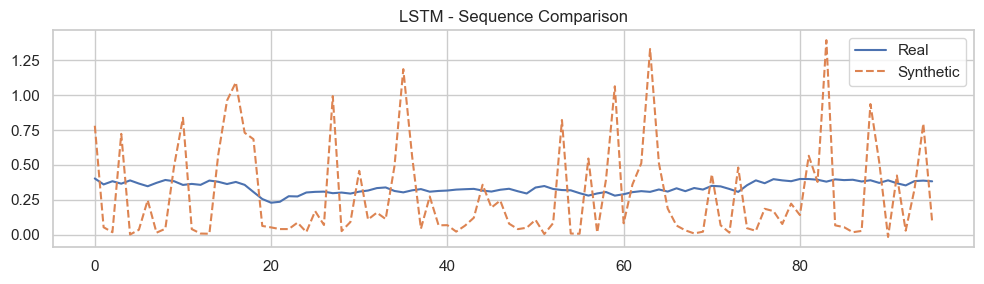

PSD Comparison...


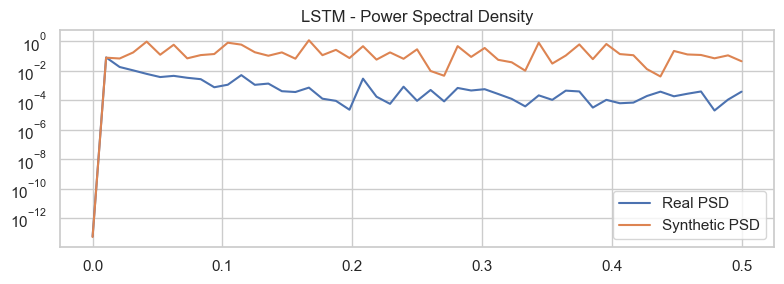

Dispatch simulation (downstream)...


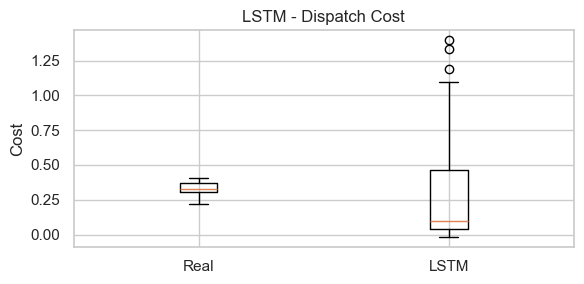

Avg Real Cost: 0.33
Avg LSTM Cost: 0.28

=== Evaluating VAE ===
→ Synthetic shape (raw): (9600, 2)
Computing MMD and Wasserstein...
MMD Score: 0.192478
Wasserstein Distance: 0.141055
KS Test (first 3 features):
 - Feature 0: KS=0.3699, p=0.0000
 - Feature 1: KS=0.9599, p=0.0000
Plotting time series (first sequence)...


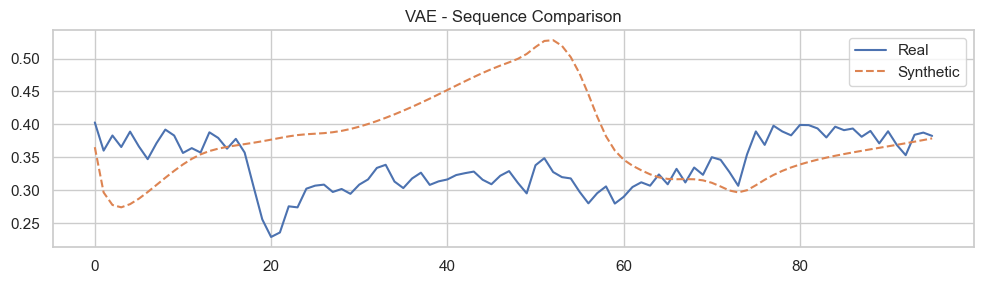

PSD Comparison...


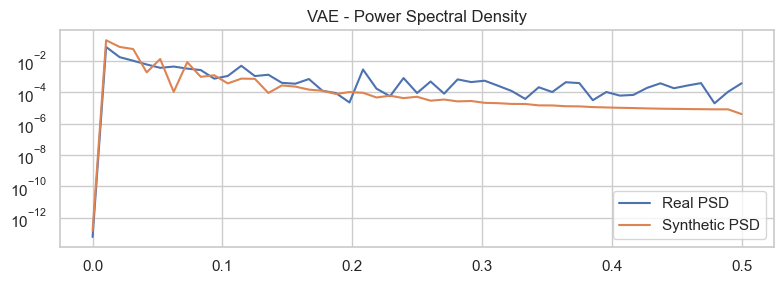

Dispatch simulation (downstream)...


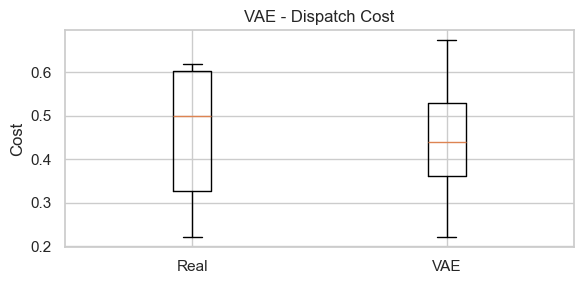

Avg Real Cost: 0.47
Avg VAE Cost: 0.45

=== Evaluating Diffusion ===
→ Synthetic shape (raw): (6400, 2)
Computing MMD and Wasserstein...
MMD Score: 0.000582
Wasserstein Distance: 0.048876
KS Test (first 3 features):
 - Feature 0: KS=0.5034, p=0.0000
 - Feature 1: KS=0.5349, p=0.0000
Plotting time series (first sequence)...


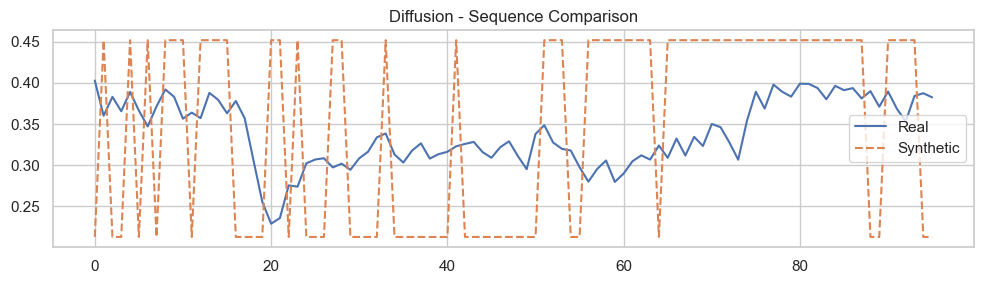

PSD Comparison...


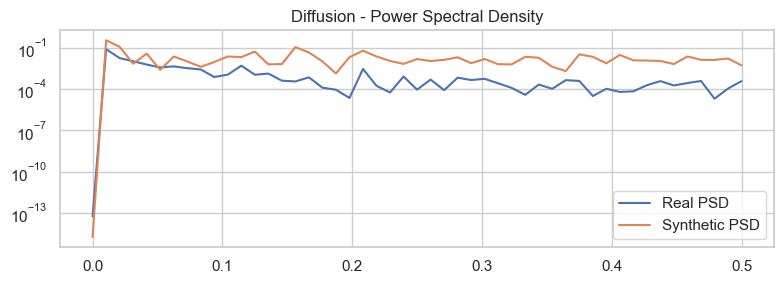

Dispatch simulation (downstream)...


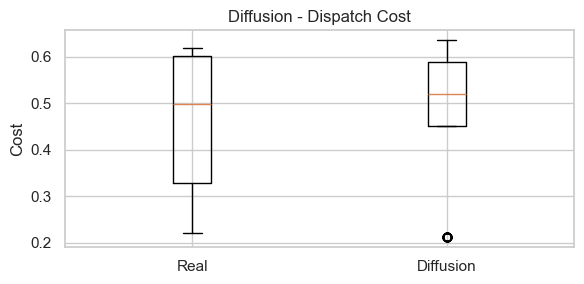

Avg Real Cost: 0.47
Avg Diffusion Cost: 0.48


In [17]:
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma)
    yy = rbf_kernel(y, y, gamma)
    xy = rbf_kernel(x, y, gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

def simulate_dispatch_cost(seq):
    base_cost = np.sum(seq)
    spike_penalty = np.sum(np.diff(seq)**2)
    return base_cost + 0.1 * spike_penalty

for name, path in model_outputs.items():
    print(f"\n=== Evaluating {name} ===")
    
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue

    synthetic = np.load(path, allow_pickle=True)
    synthetic = prepare_array(synthetic)
    print(f"→ Synthetic shape (raw): {synthetic.shape}")

    # Match dimensions
    if synthetic.shape[1] != real.shape[1]:
        print(f"Matching features: real ({real.shape[1]}) → synthetic ({synthetic.shape[1]})")
        min_dim = min(real.shape[1], synthetic.shape[1])
        real_eval = real[:, :min_dim]
        synthetic_eval = synthetic[:, :min_dim]
    else:
        real_eval = real
        synthetic_eval = synthetic

    print("Computing MMD and Wasserstein...")

    # Downsample real_eval to match synthetic_eval scale (faster MMD)
    n_samples = min(1000, len(real_eval))
    real_eval_sample = real_eval[np.random.choice(len(real_eval), n_samples, replace=False)]

    mmd_score = compute_mmd(real_eval_sample, synthetic_eval)
    wass_score = wasserstein_distance(real_eval_sample.flatten(), synthetic_eval.flatten())
    print(f"MMD Score: {mmd_score:.6f}")
    print(f"Wasserstein Distance: {wass_score:.6f}")

    print("KS Test (first 3 features):")
    for i in range(min(3, synthetic_eval.shape[1])):
        ks, pval = ks_2samp(real_eval[:, i], synthetic_eval[:, i])
        print(f" - Feature {i}: KS={ks:.4f}, p={pval:.4f}")

    print("Plotting time series (first sequence)...")
    plt.figure(figsize=(10, 3))
    plt.plot(real_eval[:96, 0], label="Real")
    plt.plot(synthetic_eval[:96, 0], label="Synthetic", linestyle='--')
    plt.title(f"{name} - Sequence Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("PSD Comparison...")
    f_real, Pxx_real = periodogram(real_eval[:96, 0])
    f_syn, Pxx_syn = periodogram(synthetic_eval[:96, 0])
    plt.figure(figsize=(8, 3))
    plt.semilogy(f_real, Pxx_real, label='Real PSD')
    plt.semilogy(f_syn, Pxx_syn, label='Synthetic PSD')
    plt.legend()
    plt.title(f"{name} - Power Spectral Density")
    plt.tight_layout()
    plt.show()

    print("Dispatch simulation (downstream)...")
    real_costs = [simulate_dispatch_cost(seq.flatten()) for seq in real_eval[:100].reshape(-1, min_dim)]
    syn_costs = [simulate_dispatch_cost(seq.flatten()) for seq in synthetic_eval[:100].reshape(-1, min_dim)]

    plt.figure(figsize=(6, 3))
    plt.boxplot([real_costs, syn_costs], labels=["Real", name])
    plt.title(f"{name} - Dispatch Cost")
    plt.ylabel("Cost")
    plt.tight_layout()
    plt.show()

    print(f"Avg Real Cost: {np.mean(real_costs):.2f}")
    print(f"Avg {name} Cost: {np.mean(syn_costs):.2f}")

In [18]:
from tabulate import tabulate

# Create list to store evaluation metrics
results = []

# Repeat the loop (but with no plotting) to gather metrics only
for name, path in model_outputs.items():
    if not os.path.exists(path):
        continue

    synthetic = np.load(path, allow_pickle=True)
    synthetic = prepare_array(synthetic)

    if synthetic.shape[1] != real.shape[1]:
        min_dim = min(real.shape[1], synthetic.shape[1])
        real_eval = real[:, :min_dim]
        synthetic_eval = synthetic[:, :min_dim]
    else:
        real_eval = real
        synthetic_eval = synthetic

    # Sample subset of real to speed up
    n_samples = min(1000, len(real_eval))
    real_sample = real_eval[np.random.choice(len(real_eval), n_samples, replace=False)]

    mmd_score = compute_mmd(real_sample, synthetic_eval)
    wass_score = wasserstein_distance(real_sample.flatten(), synthetic_eval.flatten())

    ks_scores = []
    for i in range(min(3, synthetic_eval.shape[1])):
        ks, _ = ks_2samp(real_eval[:, i], synthetic_eval[:, i])
        ks_scores.append(ks)
    ks_mean = np.mean(ks_scores)

    # Simulate cost
    real_costs = [simulate_dispatch_cost(seq.flatten()) for seq in real_eval[:100].reshape(-1, min_dim)]
    syn_costs = [simulate_dispatch_cost(seq.flatten()) for seq in synthetic_eval[:100].reshape(-1, min_dim)]
    cost_diff = abs(np.mean(real_costs) - np.mean(syn_costs))

    results.append([
        name,
        f"{mmd_score:.4f}",
        f"{wass_score:.4f}",
        f"{ks_mean:.4f}",
        f"{np.mean(syn_costs):.2f}",
        f"{cost_diff:.2f}"
    ])

# Print table
headers = ["Model", "MMD", "Wasserstein", "Avg KS (3f)", "Avg Cost", "Δ Cost from Real"]
print("\n Model Evaluation Summary:")
print(tabulate(results, headers=headers, tablefmt="github"))


 Model Evaluation Summary:
| Model     |    MMD |   Wasserstein |   Avg KS (3f) |   Avg Cost |   Δ Cost from Real |
|-----------|--------|---------------|---------------|------------|--------------------|
| LSTM      | 0.0341 |        0.2548 |        0.6281 |       0.28 |               0.05 |
| VAE       | 0.1929 |        0.1408 |        0.6649 |       0.45 |               0.02 |
| Diffusion | 0.0006 |        0.0491 |        0.5192 |       0.48 |               0.01 |


MMD and Wasserstein Bar Chart

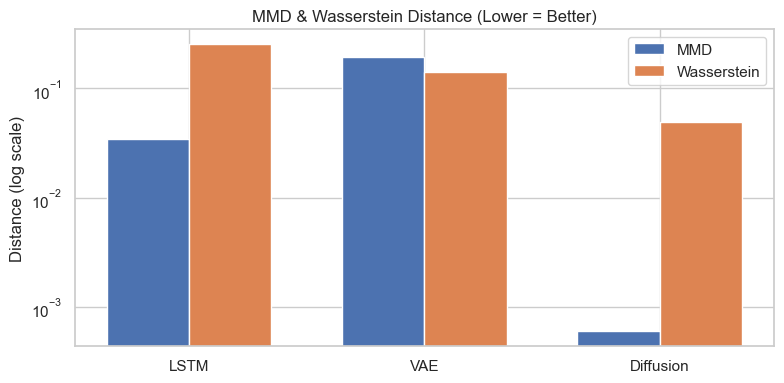

In [19]:
# Extract values from `results` if not already done
model_names = [r[0] for r in results]
mmd_scores = [float(r[1]) for r in results]
wass_scores = [float(r[2]) for r in results]

# Set up x positions for bar chart
x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, mmd_scores, width, label='MMD')
plt.bar(x + width/2, wass_scores, width, label='Wasserstein')
plt.xticks(x, model_names)
plt.yscale("log")
plt.ylabel("Distance (log scale)")
plt.title("MMD & Wasserstein Distance (Lower = Better)")
plt.legend()
plt.tight_layout()
plt.show()

KS Statistic (First 3 Features Averaged)

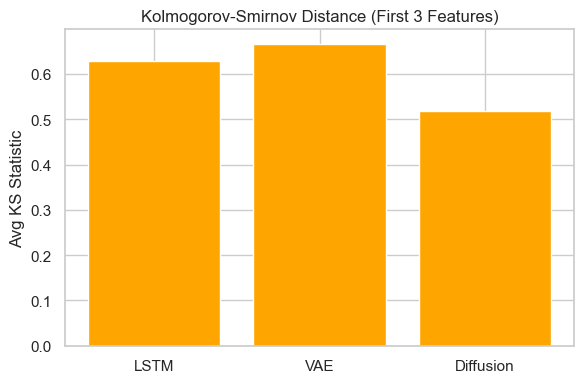

In [20]:
ks_scores = [float(r[3]) for r in results]

plt.figure(figsize=(6, 4))
plt.bar(model_names, ks_scores, color='orange')
plt.ylabel("Avg KS Statistic")
plt.title("Kolmogorov-Smirnov Distance (First 3 Features)")
plt.tight_layout()
plt.show()

Dispatch Cost Comparison

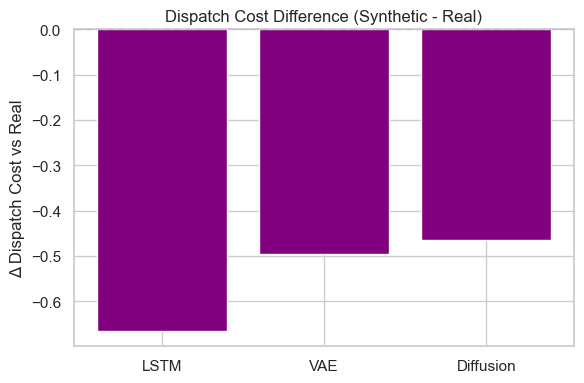

In [21]:
# Compute real baseline cost
real_avg = np.mean([simulate_dispatch_cost(seq.flatten()) for seq in real[:100]])

# Extract synthetic model costs
avg_costs = [float(r[4]) for r in results]
relative_costs = [c - real_avg for c in avg_costs]

# Plot the difference
plt.figure(figsize=(6, 4))
plt.bar(model_names, relative_costs, color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Δ Dispatch Cost vs Real")
plt.title("Dispatch Cost Difference (Synthetic - Real)")
plt.tight_layout()
plt.show()

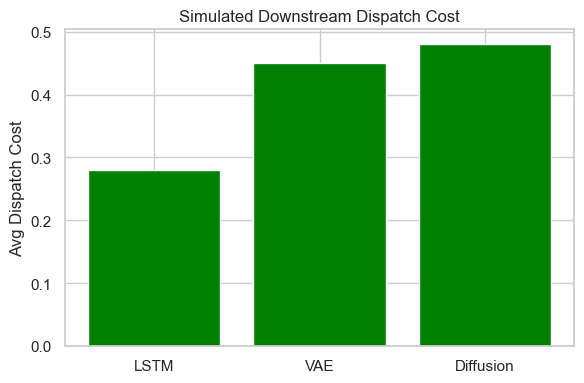

In [22]:
plt.figure(figsize=(6, 4))
plt.bar(model_names, avg_costs, color='green')
plt.ylabel("Avg Dispatch Cost")
plt.title("Simulated Downstream Dispatch Cost")
plt.tight_layout()
plt.show()